# NATS3200: Practical 6 (Random forests and Neural Networks, weeks 9 and 10) 

### William Makins-Elliott 201447107


imports + file opening:

In [130]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

In [2]:
mushroomsdf = pd.read_csv('mushrooms.csv') #reads the file and generates a pandas dataframe.
print(mushroomsdf)

         Edible CapShape CapSurface CapColor     Odor Height
0     Poisonous   Convex     Smooth    Brown  Pungent   Tall
1        Edible   Convex     Smooth   Yellow   Almond  Short
2        Edible     Bell     Smooth    White    Anise   Tall
3     Poisonous   Convex      Scaly    White  Pungent  Short
4        Edible   Convex     Smooth     Gray     None  Short
...         ...      ...        ...      ...      ...    ...
8119     Edible  Knobbed     Smooth    Brown     None   Tall
8120     Edible   Convex     Smooth    Brown     None   Tall
8121     Edible     Flat     Smooth    Brown     None  Short
8122  Poisonous  Knobbed      Scaly    Brown    Fishy  Short
8123     Edible   Convex     Smooth    Brown     None   Tall

[8124 rows x 6 columns]


### To be able to use models on this data set the data points must be quantitative not qualitative. The data frame has been converted to numbers below. It is worth noting that 'edible' is now 0 and 'poisonous' is 1 despite edible being the 'True' value, this will not effect the models but is worth remembering whe visualizing results.

In [3]:
columns = mushroomsdf.columns
mushroomsdf[columns] = mushroomsdf[columns].apply(LabelEncoder().fit_transform)
print(mushroomsdf)

      Edible  CapShape  CapSurface  CapColor  Odor  Height
0          1         2           3         0     7       1
1          0         2           3         9     0       0
2          0         0           3         8     1       1
3          1         2           2         8     7       0
4          0         2           3         3     6       0
...      ...       ...         ...       ...   ...     ...
8119       0         4           3         0     6       1
8120       0         2           3         0     6       1
8121       0         3           3         0     6       0
8122       1         4           2         0     3       0
8123       0         2           3         0     6       1

[8124 rows x 6 columns]


## Q1. Fit Random Forest models using each possible input on its own to predict edibility. Evaluate the quality of fit by using the predict function to calculate the predicted class for each mushroom (edible or poisonous). Which input fits best? (0.5 marks)

Below each single input random forest model has been created and then tested. Their respective confusion matrices have been plotted as well as a bar graph of each models accuracy.

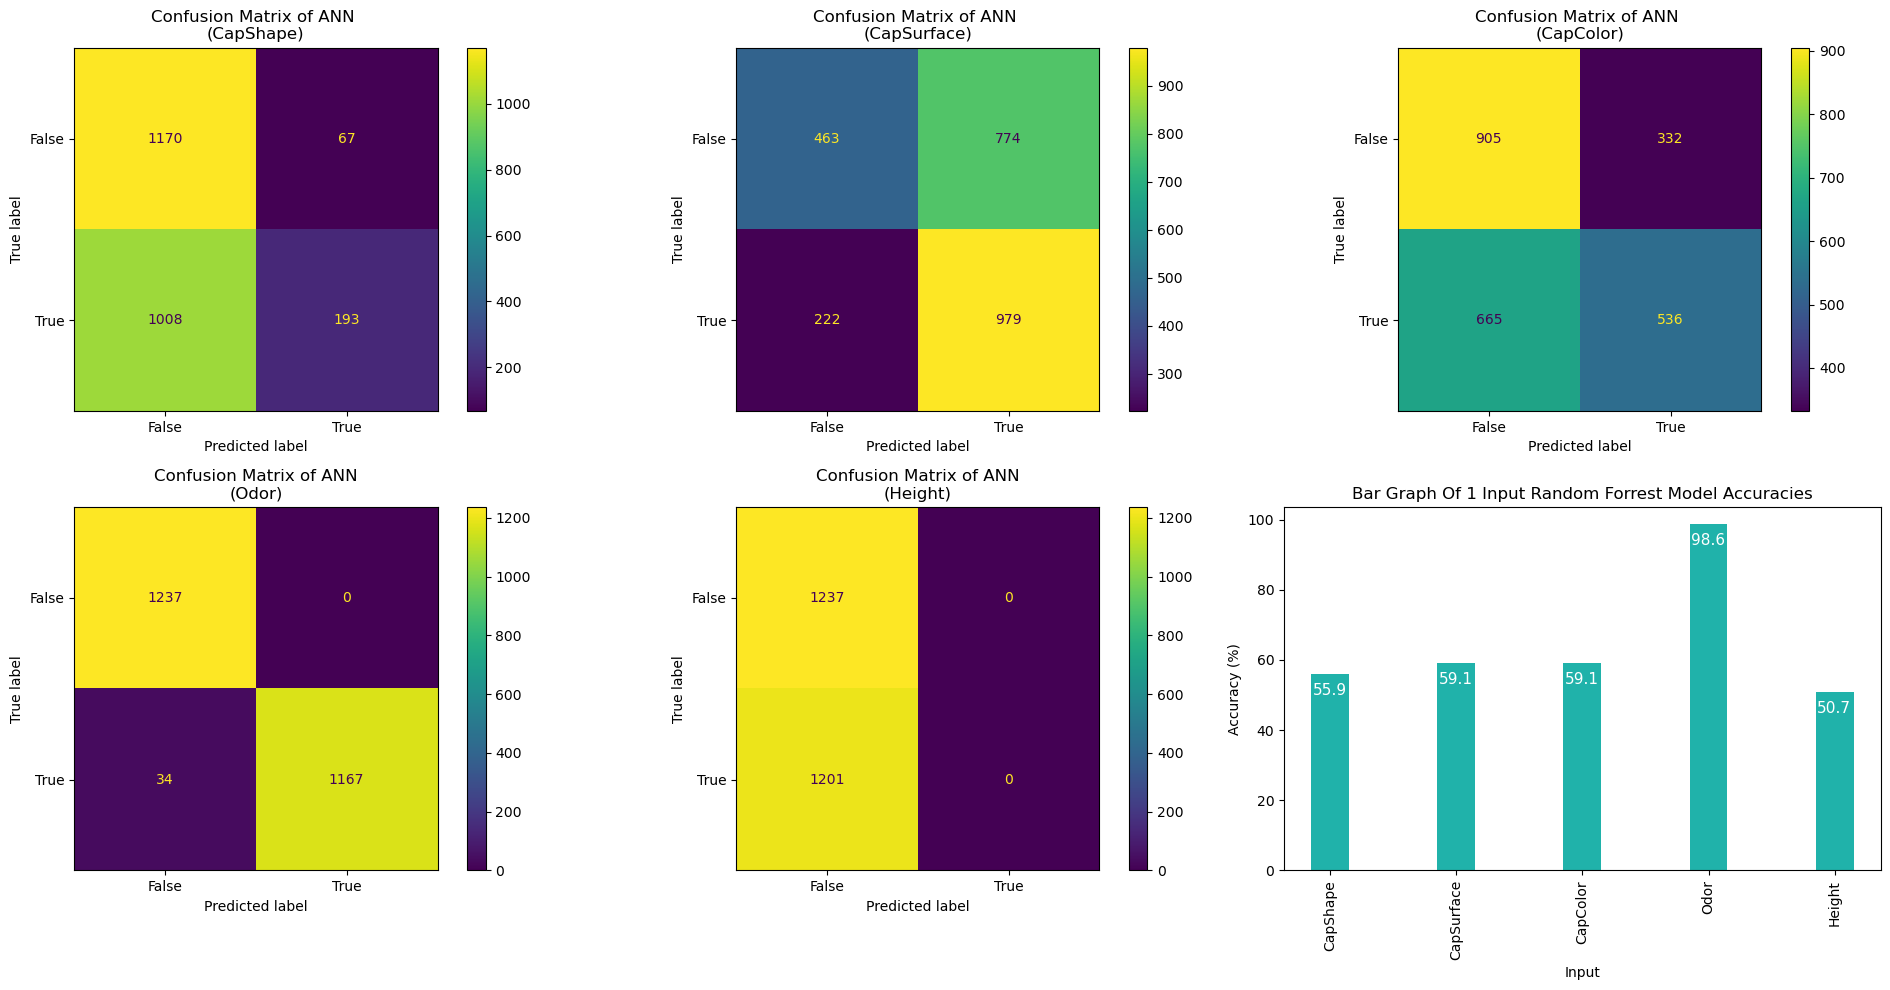

In [110]:
fig, axs = plt.subplots(2, 3,figsize=(20,10))
train_data, test_data = train_test_split(mushroomsdf,test_size=0.3)
accuracies = []
for j in range(len(columns[1:])):
    myforest = RandomForestClassifier()
    myforest.fit(np.array(train_data[columns[j+1]]).reshape(-1, 1),train_data['Edible'])
    prediction = myforest.predict_proba(np.array(test_data[columns[j+1]]).reshape(-1, 1))
    prediction1 = pd.DataFrame({'Inedible':prediction[:,0],'Edible':prediction[:,1]})
    binary_prediction = []
    for i in range(len(prediction1['Edible'])):
        if prediction1['Edible'][i] < 0.5:
            binary_prediction.append(0)
        else:
            binary_prediction.append(1)
    accuracies.append(metrics.accuracy_score(test_data['Edible'],binary_prediction)*100)
    confusion_matrix = metrics.confusion_matrix(test_data['Edible'], binary_prediction)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    if j < 3:
        cm_display.plot(ax=axs[0,j])
        axs[0,j].set_title(f'Confusion Matrix of ANN \n({columns[j+1]})')
    if j > 2:
        cm_display.plot(ax=axs[1,j-3])
        axs[1,j-3].set_title(f'Confusion Matrix of ANN\n({columns[j+1]})')        
modelnum = np.arange(5)
axs[1,2].bar(modelnum, accuracies, width=0.3,color='lightseagreen')
axs[1,2].set_xticks(range(5),['CapShape','CapSurface','CapColor','Odor','Height'],rotation='vertical')
for i in range(len(accuracies)):
    axs[1,2].annotate(f'{round(accuracies[i],1)}',xy=(0,0),xytext=(i-0.14,accuracies[i]-6),color='white',fontsize=11)
axs[1,2].set_title('Bar Graph Of 1 Input Random Forrest Model Accuracies')
axs[1,2].set_ylabel('Accuracy (%)')
axs[1,2].set_xlabel('Input')
fig.tight_layout()

From the graph above it is clear that 'Odor' is the input that fits best with an accuracy of 98.6%. The other variables have poor fits of around 50-60%. Height is an especially poor identifier with an accuracy of only 50.7%, only 0.7% better than randomly guessing.

## Q2. Using cross-validation, perform a model selection to determine which features are useful for making predictions using a Random Forest. As above, use the number of mushrooms correctly classified as the criterion for deciding which model is best.(2 marks)



In [6]:
combinations = []
inputs = ['CapShape','CapSurface','CapColor','Odor','Height']
for i in range(len(inputs) + 1):
    for subsets in itertools.combinations(inputs, i):
        if subsets != ():
            combinations.append(subsets)          
for i in range(len(combinations)):
    combinations[i] = list(combinations[i])

In [7]:
winner = []
all_accuracies = []
for _ in range(100):
    accuracies = []
    train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(mushroomsdf.drop('Edible',axis=1),mushroomsdf['Edible'],test_size=0.3)
    for i in range(len(combinations)):
        input_df = train_data_X[combinations[i]]
        test_df = test_data_X[combinations[i]]
        myforest = RandomForestClassifier()
        myforest.fit(input_df,train_data_Y)        
        prediction_01 = myforest.predict(test_df)   
        accuracy = accuracy_score(test_data_Y,prediction_01)
        accuracies.append(accuracy)
    winner.append(np.argmax(accuracies))
    all_accuracies.append(accuracies)

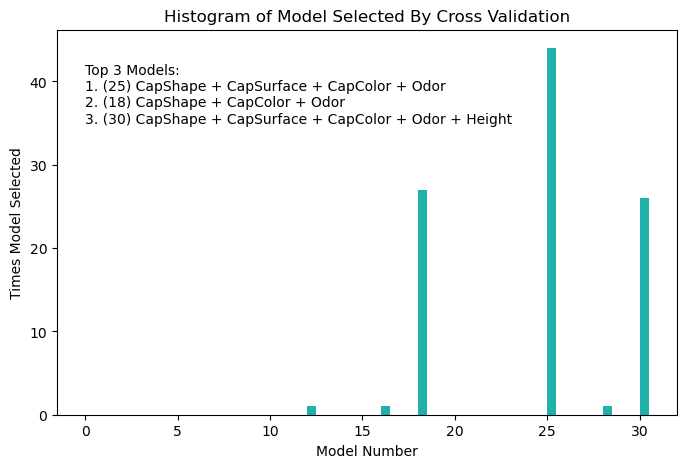

In [111]:
#I put the result from the cross validation above into a list so that I wouldn't have to run it again
winner_stored = [25, 18, 25, 25, 25, 25, 30, 30, 25, 18, 16, 18, 25, 25, 18, 18, 30, 25, 25, 30, 25, 18, 25, 18, 25, 25, 30, 30, 12, 25, 30, 25, 25, 18, 30, 25, 30, 25, 30, 30, 30, 30, 18, 25, 25, 25, 30, 25, 18, 18, 30, 18, 18, 25, 25, 25, 30, 25, 25, 18, 30, 25, 30, 18, 18, 18, 25, 18, 25, 18, 18, 28, 18, 30, 25, 25, 25, 30, 30, 30, 18, 25, 25, 25, 18, 25, 25, 30, 18, 25, 30, 30, 30, 18, 25, 18, 18, 25, 25, 25]
Counter(winner_stored)
ModelNumber = np.arange(0,len(combinations),0.5)
plt.figure(figsize=(8,5))
plt.hist(winner_stored,bins=ModelNumber, color='lightseagreen')
plt.xlabel('Model Number')
plt.ylabel('Times Model Selected')
plt.title('Histogram of Model Selected By Cross Validation')
plt.annotate('Top 3 Models:\n1. (25) CapShape + CapSurface + CapColor + Odor\n2. (18) CapShape + CapColor + Odor\n3. (30) CapShape + CapSurface + CapColor + Odor + Height',xy=(0,0),xytext=(0,35))
plt.show()

## The cross validation selects these models the most:
1. (25) CapShape + CapSurface + CapColor + Odor
2. (18) CapShape + CapColor + Odor
3. (30) CapShape + CapSurface + CapColor + Odor + Height

## Confusion matrices of these three models are plotted below:

Model: ['CapShape', 'CapSurface', 'CapColor', 'Odor'] Accuracy: 99.2
Model: ['CapShape', 'CapColor', 'Odor'] Accuracy: 99.1
Model: ['CapShape', 'CapSurface', 'CapColor', 'Odor', 'Height'] Accuracy: 99.1


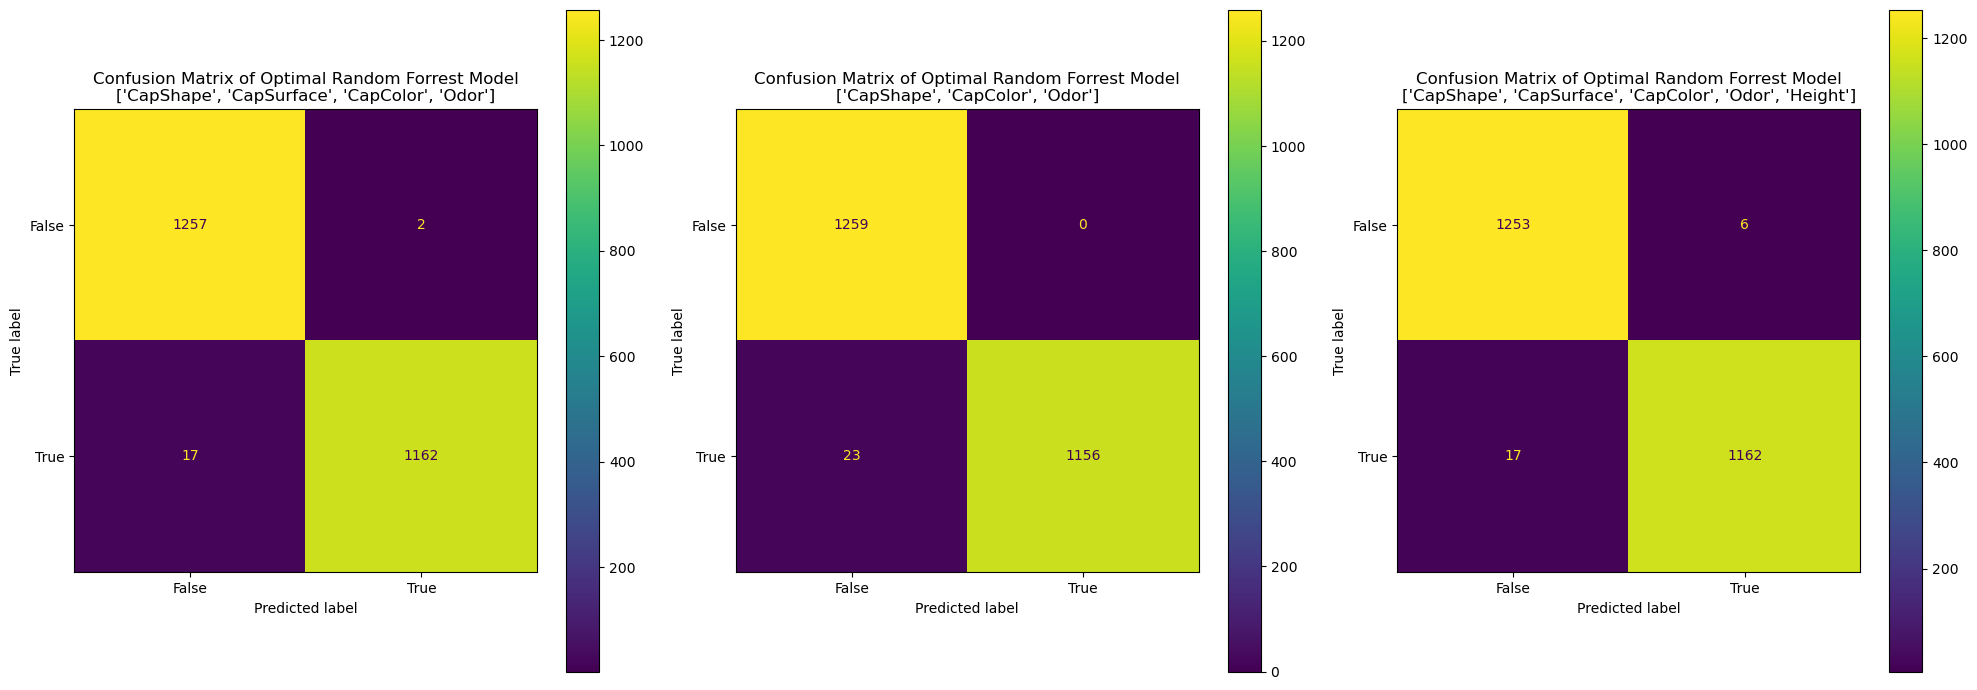

In [159]:
fig, axs = plt.subplots(1, 3,figsize=(20,7))

train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(mushroomsdf.drop('Edible',axis=1),mushroomsdf['Edible'],test_size=0.3)
top_models = [['CapShape','CapSurface','CapColor','Odor'],['CapShape','CapColor','Odor'],['CapShape','CapSurface','CapColor','Odor','Height']]
for i in range(len(top_models)):
    input_df = train_data_X[top_models[i]]
    test_df = test_data_X[top_models[i]]
    myforest = RandomForestClassifier()
    myforest.fit(input_df,train_data_Y)
    prediction = myforest.predict(test_df)
    accuracy = metrics.accuracy_score(test_data_Y,prediction)
    print(f'Model: {top_models[i]} Accuracy: {round(accuracy*100,1)}')
    confusion_matrix = metrics.confusion_matrix(test_data_Y, prediction)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot(ax=axs[i])
    axs[i].set_title(f'Confusion Matrix of Optimal Random Forrest Model\n{top_models[i]}')
fig.tight_layout()

## Q3 Would you use this classifier if you were foraging for mushrooms? Discuss with reference to factors that you identified as important and the probability of poisoning yourself.

The best three random forrest prediction models have accuracies of ~99%. This is high enough for me to use these classifiers if I was foraging for mushrooms as there is only a ~1% chance of poisoning myself if I was able to correctly describe the mushroom. The key factor to identify would be the odor of the mushroom as this is the single input that is best at identifying if a mushroom is poisoning (~98% by itself). Cap shape and color are the other properties that are important to identify. Below is further analysis on how to determine if a mushroom is poisonous based on odor. The over dependence of this model on odor does make it a weak model. The model is overly reliant on odor, this could lead to the wrong classification of a mushroom if the odor is misidentified as the other properties of the mushroom would not be able to make up for this mistake.

0 = Almond, 1 = Anise, 2 = Creosote, 3 = Fishy, 4 = Foul, 5 = Musty, 6 = None, 7 = Pungent, 8 = Spicy
Odor of edible mushrooms and number of mushrooms {0: 400, 1: 400, 6: 3408}
Odor of inedible mushrooms and number of mushrooms {7: 256, 4: 2160, 2: 192, 3: 576, 6: 120, 8: 576, 5: 36}
All mushrooms Counter({6: 3528, 4: 2160, 3: 576, 8: 576, 0: 400, 1: 400, 7: 256, 2: 192, 5: 36})


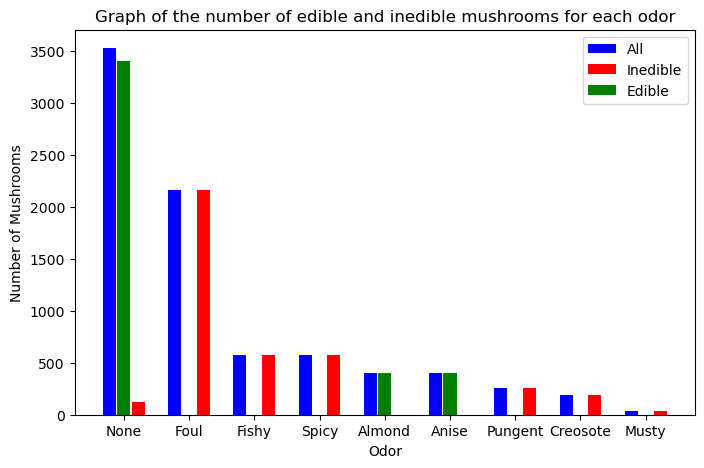

In [151]:
list_odor = list(mushroomsdf['Odor'])
list_edible = list(mushroomsdf['Edible'])
odor_dict = Counter(mushroomsdf['Odor'])
odor_edible_dict = {}
odor_inedible_dict ={}
for i in range(len(list_odor)):
    if list_edible[i] == 0:
        if list_odor[i] in odor_edible_dict:
            odor_edible_dict[list_odor[i]] += 1
        else:
            odor_edible_dict[list_odor[i]] = 1
for i in range(len(list_odor)):
    if list_edible[i] == 1:
        if list_odor[i] in odor_inedible_dict:
            odor_inedible_dict[list_odor[i]] += 1
        else:
            odor_inedible_dict[list_odor[i]] = 1
print('0 = Almond, 1 = Anise, 2 = Creosote, 3 = Fishy, 4 = Foul, 5 = Musty, 6 = None, 7 = Pungent, 8 = Spicy')
print('Odor of edible mushrooms and number of mushrooms',odor_edible_dict)
print('Odor of inedible mushrooms and number of mushrooms',odor_inedible_dict)
print('All mushrooms',odor_dict)
plt.figure(figsize=(8,5))
plt.bar(np.linspace(0,8,9)-0.22,[3528,2160,576,576,400,400,256,192,36],color='b',label='All',width=0.2)
plt.bar(np.linspace(0,8,9)+0.22,[120,2160,576,576,0,0,256,192,36],color='r',label='Inedible',width=0.2)
plt.bar(np.linspace(0,8,9),[3408,0,0,0,400,400,0,0,0],color='g',label='Edible',width=0.2)
plt.legend()
plt.xticks([0,1,2,3,4,5,6,7,8],['None','Foul','Fishy','Spicy','Almond','Anise','Pungent','Creosote','Musty'])
plt.xlabel('Odor')
plt.ylabel('Number of Mushrooms')
plt.title('Graph of the number of edible and inedible mushrooms for each odor')
plt.show()

The graph above shows how to classify mushrooms based on their odor. In this data set the only odor that has both edible and inedible mushrooms is no odor. Mushrooms that are safe to eat are ones that smell of 'Almond', 'Anise' and the majority of those with no odor. All mushrooms with 'Foul', 'Fishy', 'Spicy', 'Pungent', 'Creosote', and 'Musty' odors should be considered poisonous.

## Q4. Fit an ANN module using each possible input on its own to predict edibility.Evaluate the quality of fit by using the predict function to calculate the predicted class for each mushroom (edible or poisonous). Which input fits best? (i.e. which classifies the most mushrooms correctly?)

Below I have created the single input ANN models and found their accuracy, from which their confusion matrices have been plotted. A graph of the models accuracies ahs also been plotted to identity the winner.

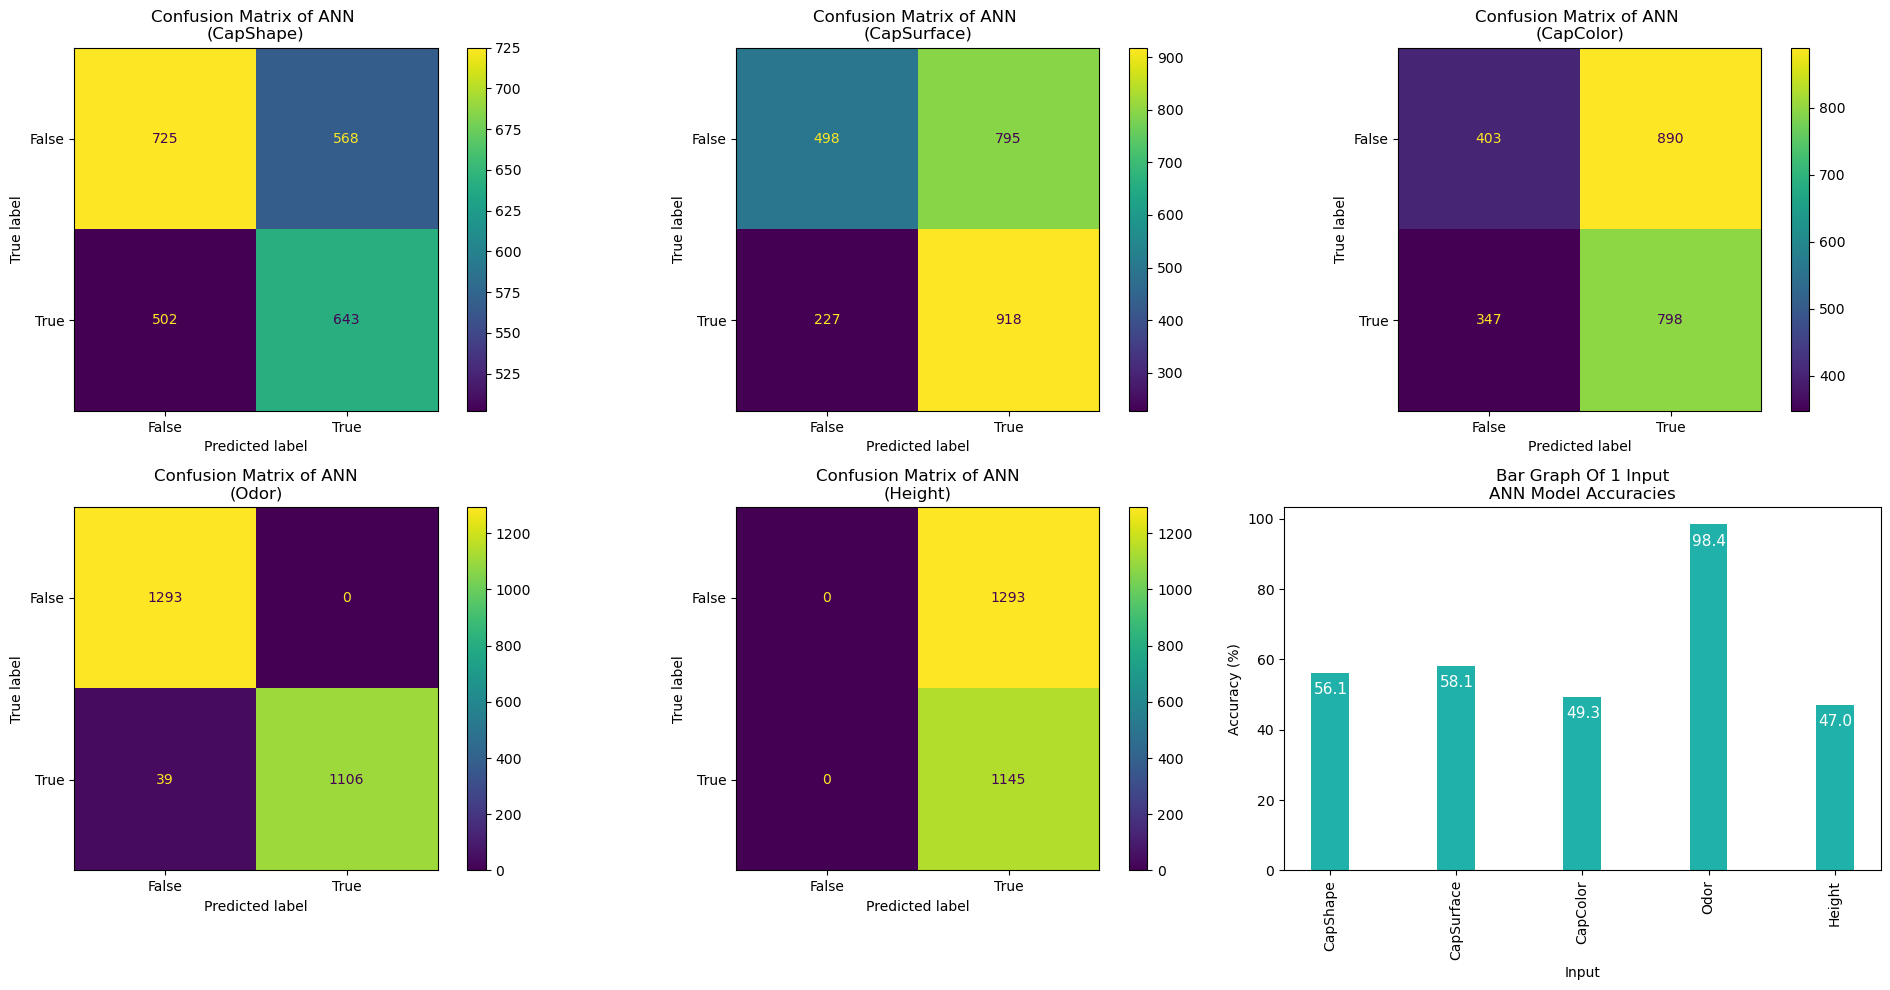

In [12]:
fig, axs = plt.subplots(2, 3,figsize=(20,10))
train_data, test_data = train_test_split(mushroomsdf,test_size=0.3)
ANN_accuracies = []
for j in range(len(columns[1:])):
    clf = MLPClassifier(solver='sgd',learning_rate_init=0.1,hidden_layer_sizes=(10,),activation='logistic',max_iter=2000)
    clf.fit(np.array(train_data[columns[j+1]]).reshape(-1, 1), train_data['Edible'])
    predictions = clf.predict(np.array(test_data[columns[j+1]]).reshape(-1, 1))
    correct_count = 0
    for i in range(len(list(test_data['Edible']))):
        if list(test_data['Edible'])[i] == predictions[i]:
            correct_count = correct_count + 1
    ANN_accuracies.append(100*(correct_count/(len(list(test_data['Edible'])))))
    confusion_matrix = metrics.confusion_matrix(test_data['Edible'], predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    if j < 3:
        cm_display.plot(ax=axs[0,j])
        axs[0,j].set_title(f'Confusion Matrix of ANN \n({columns[j+1]})')
    if j > 2:
        cm_display.plot(ax=axs[1,j-3])
        axs[1,j-3].set_title(f'Confusion Matrix of ANN\n({columns[j+1]})')        
modelnum = np.arange(5)
axs[1,2].bar(modelnum, ANN_accuracies, width=0.3,color='lightseagreen')
axs[1,2].set_xticks(range(5),['CapShape','CapSurface','CapColor','Odor','Height'],rotation='vertical')
for i in range(len(ANN_accuracies)):
    axs[1,2].annotate(f'{round(ANN_accuracies[i],1)}',xy=(0,0),xytext=(i-0.13,ANN_accuracies[i]-6),color='white',fontsize=11)
axs[1,2].set_title('Bar Graph Of 1 Input\nANN Model Accuracies')
axs[1,2].set_ylabel('Accuracy (%)')
axs[1,2].set_xlabel('Input')
fig.tight_layout()


From the graphs above it is clear that as with the random forrest models the single input ANN models are best fitted by 'Odor'. The other variables have low accuracies, especially CapColor and Height with accuracies of 49.3 and 47.0 respectively (worse then randomly guessing the result).

## Q5. Explore how the performance depends on the architecture of the ANN. Vary the number and the sizes of the hidden layers. For large networks you may want to increase the number of the stochastic gradient descent iterations. (1 mark)

The effects of varying learning rate and hidden layer sizes is shown below. The number of stochastic gradient decent iterations has been kept high at 3000 for all models to ensure that the network always converges. The optimization of these parameters is done on a model that takes all possible variables from the data set.

### Varying Hidden Layer Size: 
(learning rate kept as default)

In [112]:
train_data, test_data = train_test_split(mushroomsdf,test_size=0.3)
accas_hls = []
for i in range(1,100):
    clf = MLPClassifier(solver='sgd',learning_rate_init=0.001,hidden_layer_sizes=(i,),activation='logistic',max_iter=3000)
    clf.fit(train_data.drop('Edible',axis=1), train_data['Edible'])
    predictions = clf.predict(test_data.drop('Edible',axis=1))
    accuracy = metrics.accuracy_score(test_data['Edible'],predictions)
    accas_hls.append(accuracy)
print(accas_hls)

[0.5200984413453651, 0.5200984413453651, 0.682526661197703, 0.8683347005742412, 0.8863822805578343, 0.8695652173913043, 0.8990976210008204, 0.8351107465135357, 0.8990976210008204, 0.8638228055783429, 0.8933552091878589, 0.8921246923707957, 0.8958162428219852, 0.8941755537325676, 0.9023789991796555, 0.8995077932731748, 0.904019688269073, 0.9401148482362592, 0.9232977850697293, 0.9130434782608695, 0.8982772764561116, 0.9163248564397046, 0.9077112387202625, 0.928219852337982, 0.9339622641509434, 0.9093519278096801, 0.9097621000820345, 0.92616899097621, 0.9138638228055783, 0.9356029532403609, 0.9253486464315013, 0.9249384741591469, 0.9302707136997539, 0.9216570959803118, 0.9417555373256767, 0.9405250205086136, 0.9454470877768663, 0.9339622641509434, 0.938884331419196, 0.938884331419196, 0.9339622641509434, 0.9511894995898277, 0.9520098441345365, 0.9351927809680065, 0.9438063986874488, 0.948318293683347, 0.9306808859721083, 0.9253486464315013, 0.9438063986874488, 0.9360131255127153, 0.93765

<function matplotlib.pyplot.show(close=None, block=None)>

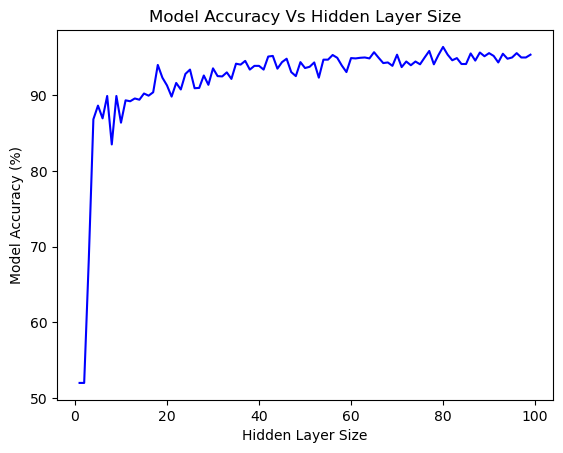

In [114]:
plt.plot(range(1,100),np.multiply(accas_hls,100),'b')
#plt.plot(range(1,100),np.multiply(accas_hls,100),'rx')
plt.ylabel('Model Accuracy (%)')
plt.xlabel('Hidden Layer Size')
plt.title('Model Accuracy Vs Hidden Layer Size')
plt.show

Generally the greater the hidden layer size the more capacity the network has to learn complex patterns in data as shown in the graph above by the plateau in accuracy at higher hidden layer sizes. However, it can also lead to over-fitting where the network is overly specialized to the training data and fails to generalize to test data. Therefore the optimal hidden layer size is ~75 as this is where the accuracy levels off (over-fitting wasn't reached in the graph above).

### Varying Learning Rate:
(Hidden layer size of 75)

In [52]:
all_accas = []
lrs = np.linspace(0.003,0.2,80)
for _ in range(30):
    train_data, test_data = train_test_split(mushroomsdf,test_size=0.3)
    accas = []
    for i in lrs:
        clf = MLPClassifier(solver='sgd',learning_rate_init=i,hidden_layer_sizes=(75,),activation='logistic',max_iter=3000)
        clf.fit(train_data.drop('Edible',axis=1), train_data['Edible'])
        predictions = clf.predict(test_data.drop('Edible',axis=1))
        accuracy = metrics.accuracy_score(test_data['Edible'],predictions)
        accas.append(accuracy)
    all_accas.append(accas)


Text(0.5, 1.0, 'Model Accuracy Vs Learning Rate')

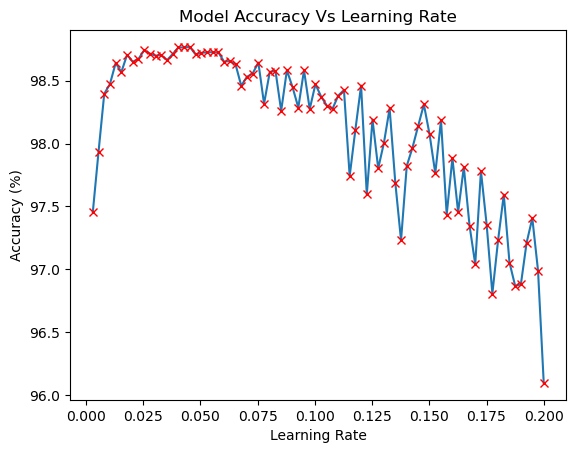

In [65]:
trans_accas = np.transpose(all_accas)
mean_accas = [np.mean(i) for i in trans_accas]
# I have stored the result from the cell above as it takes ~3h to run in case I reset the kernel by accident
mean_accas_stored = [0.9745556467049494, 0.9793409898824172, 0.9839622641509432, 0.9847415914684169, 0.9864096253759913, 0.9856986601039103, 0.9870659010117584, 0.9865190046486192, 0.9867377631938746, 0.9874350560568772, 0.9871616078753078, 0.9869975389663658, 0.9870522286026799, 0.9866420563303254, 0.9871342630571507, 0.987653814602133, 0.987653814602133, 0.9876948318293682, 0.9870932458299152, 0.9872162975116214, 0.9872709871479354, 0.9872709871479356, 0.987257314738857, 0.9865190046486191, 0.9865736942849331, 0.9863139185124419, 0.984604867377632, 0.9853158326497128, 0.985575608422204, 0.9864506426032269, 0.9831692644243916, 0.9856986601039102, 0.9857943669674597, 0.9826086956521739, 0.9858353841946952, 0.9844818156959257, 0.982868471424665, 0.9858353841946951, 0.9827454197429586, 0.9847279190593383, 0.9837435056056877, 0.9830188679245283, 0.9827727645611158, 0.9838255400601587, 0.98426305715067, 0.9774131802023518, 0.981104730653541, 0.9846185397867103, 0.9759502324309542, 0.9819114027891716, 0.9780284386108832, 0.9800519551544983, 0.9828001093792726, 0.9768662838392125, 0.9722996992070002, 0.9782198523379821, 0.9796691277003009, 0.9814055236532677, 0.9831145747880775, 0.9807355756084223, 0.9776319387476072, 0.9818567131528576, 0.9743505605687722, 0.978848783155592, 0.974541974295871, 0.9781378178835111, 0.9734755263877496, 0.9703992343450917, 0.9778096800656276, 0.973543888433142, 0.9680612523926715, 0.9722996992070002, 0.9759365600218757, 0.9705359584358765, 0.9686628383921249, 0.9688132348919879, 0.9721082854799015, 0.9740634399781241, 0.9698933552091877, 0.9609515996718622]
plt.plot(np.linspace(0.003,0.2,80),np.multiply(mean_accas_stored,100))
plt.plot(np.linspace(0.003,0.2,80),np.multiply(mean_accas_stored,100),'rx')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Vs Learning Rate')
plt.show()

A learning rate that is too high can make the network fail to converge on a good solution. However a learning rate that is too low can cause the network to converge extremely slowly or get interfered with by local minima. Both of these effects are visible in the graph above where low and high learning rates lead to a decrease in accuracy. Therefore, the optimal learning rate is roughly 0.05, as between the range of 0.035 to 0.065 the neural network has the most consistently high accuracy.

## Q6 Using cross-validation, perform a model selection to determine which features are useful for making predictions using the ANN. As above, use the number of mushrooms correctly classified as the criterion for deciding which model is best. (2 marks)

In this cross validation the optimal values of hidden layer size and learning rate were used for all models:
- hidden layer size = 75
- learning rate = 0.05
- stochastic gradient decent iterations = 3000

In [72]:
winner = []
for _ in range(100):
    accuracies = []
    train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(mushroomsdf.drop('Edible',axis=1),mushroomsdf['Edible'],test_size=0.3)
    for i in range(len(combinations)):
        input_df = train_data_X[combinations[i]]
        test_df = test_data_X[combinations[i]]
        clf = MLPClassifier(solver='sgd',learning_rate_init=0.05,hidden_layer_sizes=(75,),activation='logistic',max_iter=3000)
        clf.fit(input_df, train_data_Y)
        predictions = clf.predict(test_df)
        accuracy = metrics.accuracy_score(test_data_Y,predictions)
        accuracies.append(accuracy)
    winner.append(np.argmax(accuracies))

Counter({25: 33, 30: 32, 18: 10, 28: 8, 21: 8, 29: 5, 16: 1, 10: 1, 24: 1, 27: 1})


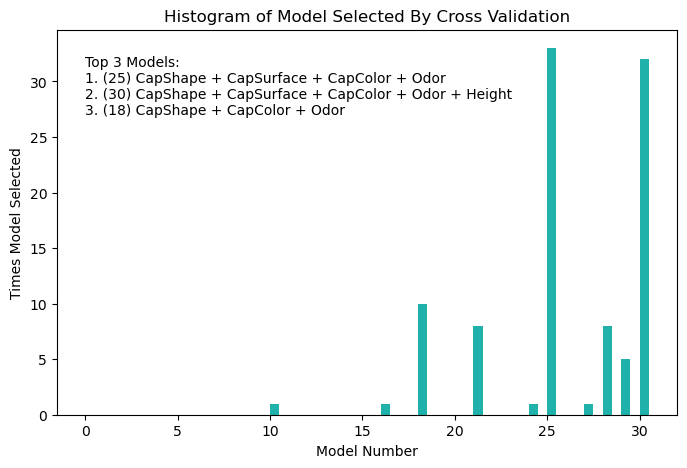

In [84]:
#Results from above stored in the list below as it takes ~2-3 hour to run
ANN_CV_stored = [30, 18, 28, 25, 30, 18, 25, 30, 25, 25, 30, 25, 28, 30, 25, 25, 30, 25, 30, 30, 25, 30, 30, 25, 29, 28, 28, 25, 28, 18, 28, 29, 18, 25, 30, 25, 25, 30, 18, 29, 25, 28, 25, 16, 30, 18, 21, 21, 25, 25, 21, 21, 25, 25, 30, 25, 25, 30, 25, 21, 30, 25, 30, 25, 30, 10, 30, 18, 30, 30, 30, 25, 25, 30, 25, 28, 30, 30, 18, 30, 18, 25, 30, 21, 29, 21, 30, 24, 30, 25, 25, 21, 30, 29, 18, 25, 25, 27, 30, 30]
print(Counter(ANN_CV_stored))
ModelNumber = np.arange(0,len(combinations),0.5)
plt.figure(figsize=(8,5))
plt.hist(ANN_CV_stored,bins=ModelNumber, color='lightseagreen')
plt.xlabel('Model Number')
plt.ylabel('Times Model Selected')
plt.title('Histogram of ANN Models Selected By Cross Validation')
plt.annotate('Top 3 Models:\n1. (25) CapShape + CapSurface + CapColor + Odor\n2. (30) CapShape + CapSurface + CapColor + Odor + Height\n3. (18) CapShape + CapColor + Odor',xy=(0,0),xytext=(0,27),fontsize=10)
plt.show()

## The cross validation selects these models the most:
1. (25) CapShape + CapSurface + CapColor + Odor
2. (30) CapShape + CapSurface + CapColor + Odor + Height
3. (18) CapShape + CapColor + Odor

The cross validation of ANN models agrees with the cross validation of random forrest models by selected model 25 as the best model. Models 30 and 18 are selected as the 2nd and 3rd best models for ANN models and the 3nd and 2st best for random forrest models. 

## Confusion matrices of these three models are plotted below:

Model Inputs: ['CapShape', 'Odor', 'CapSurface', 'CapColor'], Accuracy: 97.949
Model Inputs: ['CapShape', 'CapSurface', 'CapColor', 'Odor', 'Height'], Accuracy: 98.523
Model Inputs: ['CapShape', 'CapColor', 'Odor'], Accuracy: 97.293


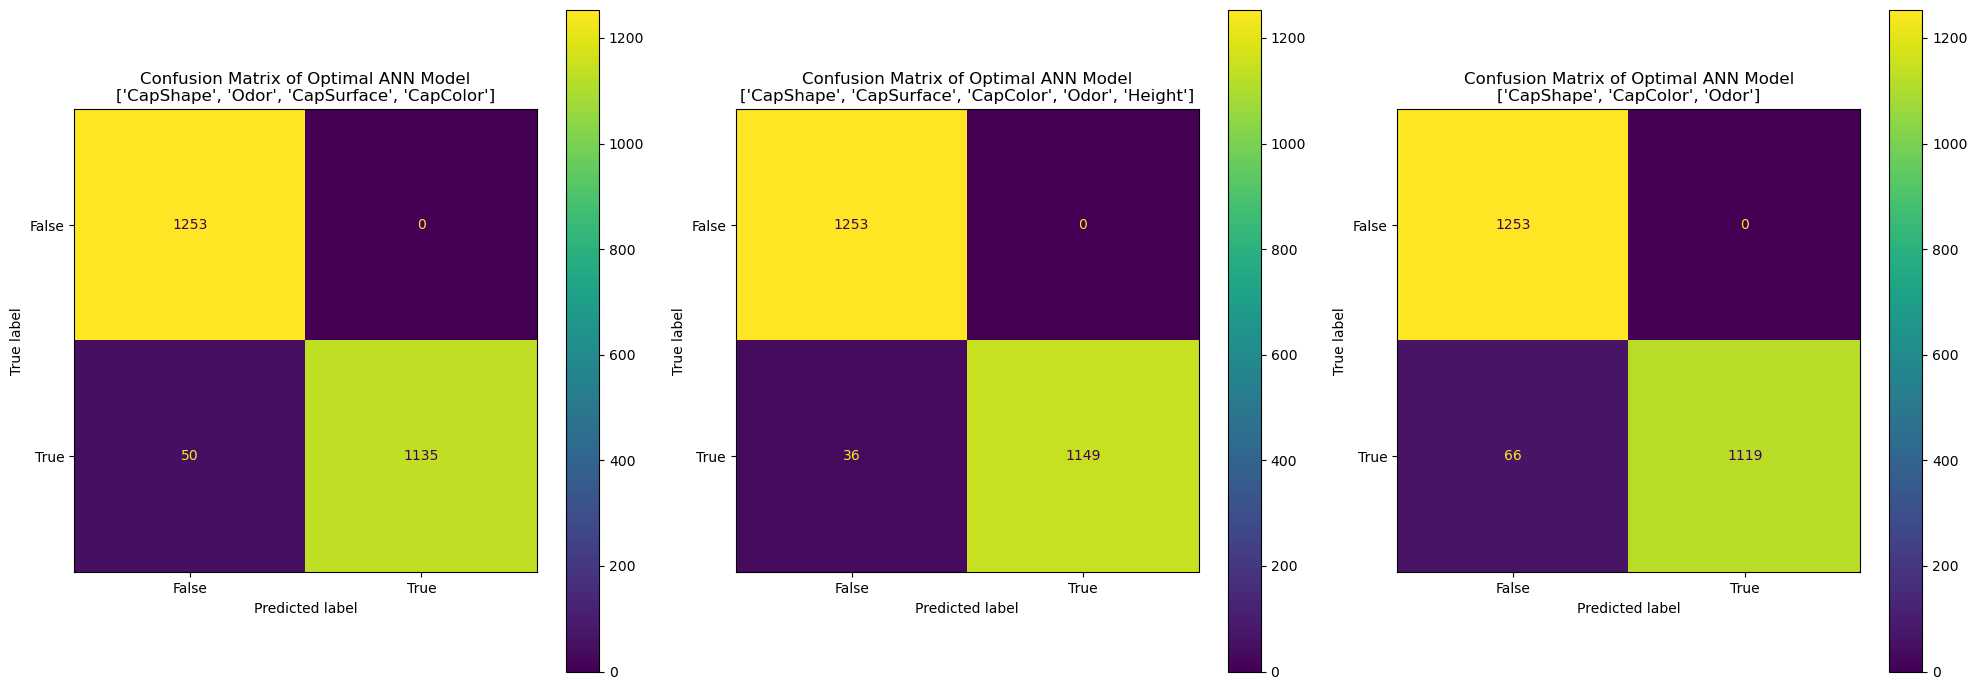

In [158]:
fig, axs = plt.subplots(1, 3,figsize=(20,7))
train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(mushroomsdf.drop('Edible',axis=1),mushroomsdf['Edible'],test_size=0.3)
top_models = [['CapShape','Odor','CapSurface','CapColor'],['CapShape','CapSurface','CapColor','Odor','Height'],['CapShape','CapColor','Odor']]
for i in range(len(top_models)):
    input_df = train_data_X[top_models[i]]
    test_df = test_data_X[top_models[i]]
    clf = MLPClassifier(solver='sgd',learning_rate_init=0.05,hidden_layer_sizes=(75,),activation='logistic',max_iter=3000)
    clf.fit(input_df, train_data_Y)
    predictions = clf.predict(test_df)
    accuracy = metrics.accuracy_score(test_data_Y,predictions)
    print(f'Model Inputs: {top_models[i]}, Accuracy: {round(accuracy*100,3)}')
    confusion_matrix = metrics.confusion_matrix(test_data_Y, predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot(ax=axs[i])
    axs[i].set_title(f'Confusion Matrix of Optimal ANN Model\n{top_models[i]}')
fig.tight_layout()

## Q7. Compare the performance of Random Forest and ANN models (0.5 marks).

#### Random Forrest models:
- Ensemble learning model that uses many decision trees to make a final prediction.
- Suited to tabular numerical data with a lot of columns and rows.
- Can handle noisy and incomplete data.
- Easy to understand.
- In this data set random forrest models achieve an accuracy of ~99%.

#### ANN models:
- A deep learning model that uses many levels of connected nodes to learn patterns in data.
- Can handle tabular numerical data as well as images, text and audio when implemented correctly.
- Requires a lot of data and computational resources to train effectively.
- Hard to understand, connections between nodes complex.
- In this data set ANN models achieve and accuracy of ~98%.

In terms of model accuracy the two methods are even. However, random forests should be used for this data set as they are easier to interoperate and require less computational resources to optimize. For example cross validation took ~13m for random forests and ~160m for ANNs. ANN models would be suited to more complex data. The confusion matrices and the feature importance's of the 2 models are shown below


Accuracy of ANN Model: 98.975%
Accuracy of Random Forrest Model: 99.303%


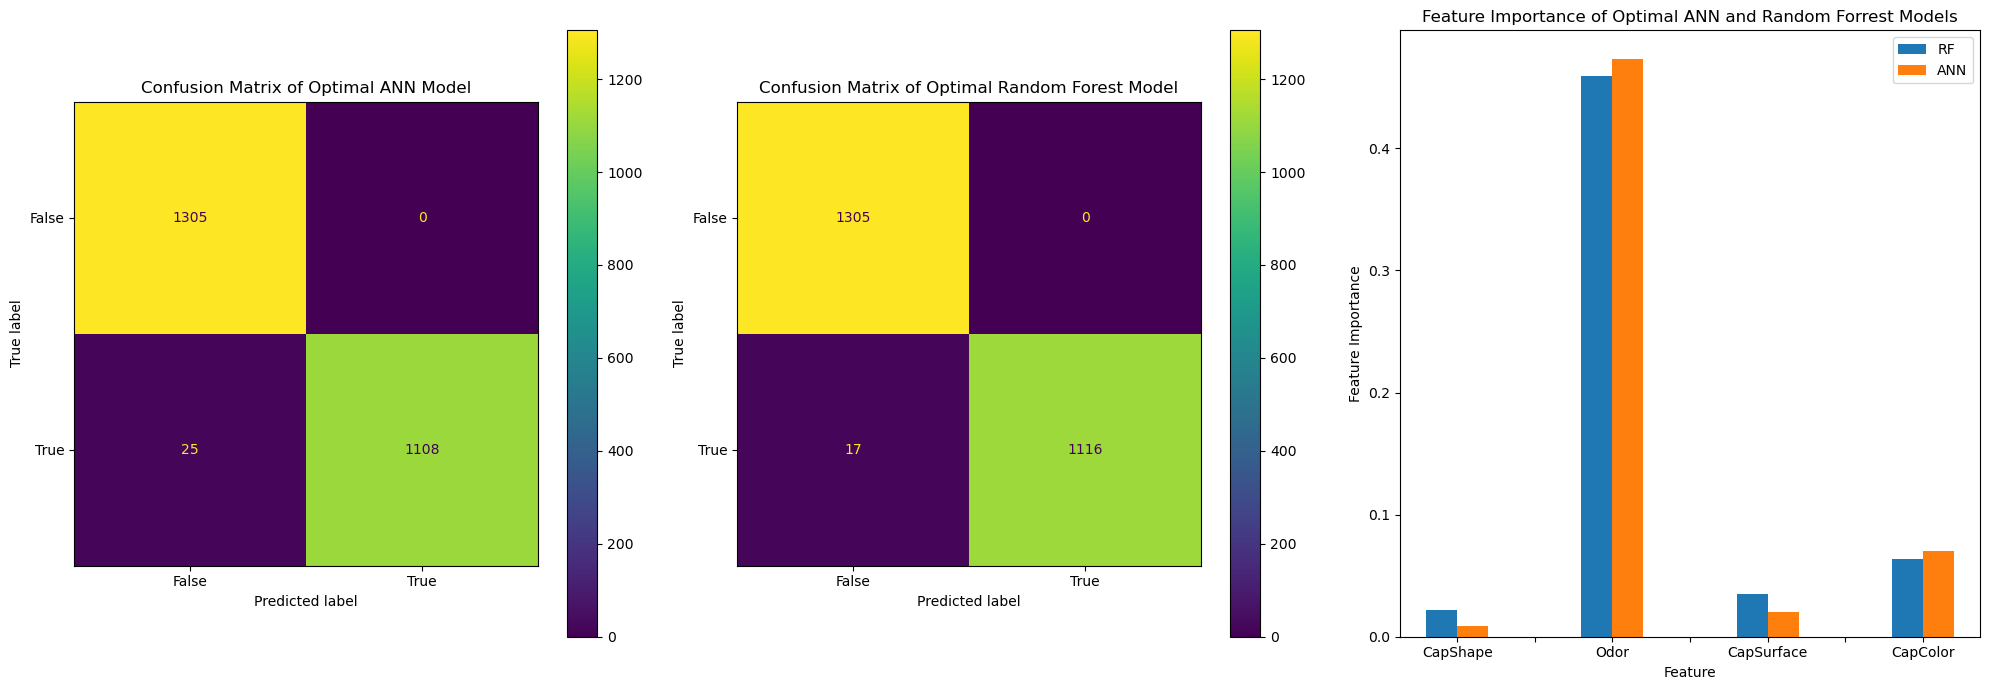

In [205]:
fig, axs = plt.subplots(1, 3,figsize=(20,7))
train_data_X, test_data_X, train_data_Y ,test_data_Y = train_test_split(mushroomsdf.drop('Edible',axis=1),mushroomsdf['Edible'],test_size=0.3)
top_model = ['CapShape','Odor','CapSurface','CapColor']
input_df = train_data_X[top_model]
test_df = test_data_X[top_model]
clf = MLPClassifier(solver='sgd',learning_rate_init=0.05,hidden_layer_sizes=(75,),activation='logistic',max_iter=3000)
clf.fit(input_df, train_data_Y)
predictions = clf.predict(test_df)
accuracy = metrics.accuracy_score(test_data_Y,predictions)
confusion_matrix = metrics.confusion_matrix(test_data_Y, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(ax=axs[0])
axs[0].set_title('Confusion Matrix of Optimal ANN Model')
print(f'Accuracy of ANN Model: {round(accuracy*100,3)}%')
importance_ANN = permutation_importance(clf, test_df, test_data_Y,n_repeats=30,random_state=0)['importances_mean']

myforest = RandomForestClassifier()
myforest.fit(input_df,train_data_Y)
predictions = myforest.predict(test_df)
accuracy = metrics.accuracy_score(test_data_Y,predictions)
confusion_matrix = metrics.confusion_matrix(test_data_Y, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot(ax=axs[1])
axs[1].set_title('Confusion Matrix of Optimal Random Forest Model')
print(f'Accuracy of Random Forrest Model: {round(accuracy*100,3)}%')
importance_RF = permutation_importance(myforest, test_df, test_data_Y,n_repeats=30,random_state=0)['importances_mean']

axs[2].bar(np.subtract([0,1,2,3],0.1),importance_RF, width=0.2,label='RF')
axs[2].bar(np.add([0,1,2,3],0.1),importance_ANN, width=0.2,label='ANN')
axs[2].set_xticks([0.0,0.5,1.0,1.5,2.0,2.5,3.0],['CapShape','','Odor','','CapSurface','','CapColor'])
axs[2].set_xlabel('Feature')
axs[2].set_ylabel('Feature Importance')
axs[2].set_title('Feature Importance of Optimal ANN and Random Forrest Models')
axs[2].legend()

fig.tight_layout()


From the figures above one can see the slightly higher accuracy of the random forrest model. The random forrest model also relies slightly less on odor, and more on other variables then the ANN model making it a more reliable model as seen in the feature importance graph.


## Self Assessment.

- Q1. I successfully fitted random forest models to each of the variables individually and compared the models using the predict function and evaluated the results. (0.5/0.5)

- Q2. I successfully ran cross validation based on accuracy for all possible random forrest models, found the top three models and plotted their confusion matrices. (2/2)

- Q3. I successfully evaluated the pros and cons of the model if I was using it. I covered the probability of poisoning myself and the important features. (0.5/0.5)

- Q4. I successfully fitted ANN models to each of the variables individually and compared the models using the predict function and evaluated the results. (0.5/0.5)

- Q5. I successfully explored the architecture of the ANN and optimized it by varying learning rate, hidden layer size and keeping the number of stochastic gradient decent iterations high to ensure convergence. Also covered affects of varying each parameter. (1/1)

- Q6. I successfully ran cross validation based on accuracy for all possible ANN models with the optimized parameters found in Q5, found the top three models and plotted their confusion matrices. These three models agreed with the top three random forrest models from Q2. (2/2)

- Q7. I successfully evaluated the pros and cons of random forrest and ANN models and compared the performance of the top ANN and random forrest models found in previous questions.  (/0.5)

- Q8. I think my work is presented well, clear figures captions and use of markdown cells to evaluate results. (2/2)

- Q9. For Q1 I plotted confusion matrices for all models. For Q2 I evaluated top three models from cross validation, plotting their confusion matrices and printing accuracies. For Q3 I explored the key variable in classification 'Odor'. For Q4 I plotted confusion matrices for all individual input models. For Q5 I explored learning rate as well as to suggested hidden layer size and number of stochastic gradient decent iterations. For Q6 I evaluated top three models from cross validation, plotting their confusion matrices and printing accuracies. For Q7 I compared ANNs and random forests generally as well as within the context of the models made and compared feature importance. (1/1)

Overall 10/10

All work is my own.